In [1]:
!pip install tensorflow

In [2]:
# Import basic libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import kagglehub
rice_image_dataset = kagglehub.dataset_download('muratkokludataset/rice-image-dataset')

In [4]:
# Dataset path - make sure it exists
dataset_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

In [5]:
# Create DataFrame of images and labels
data = []

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            data.append({
                "image_path": image_path,
                "label": class_name
            })

In [6]:
# Create the DataFrame
df = pd.DataFrame(data)

# Show a few sample rows
print("Total images:", len(df))
df.head()

Total images: 75000


,image_path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


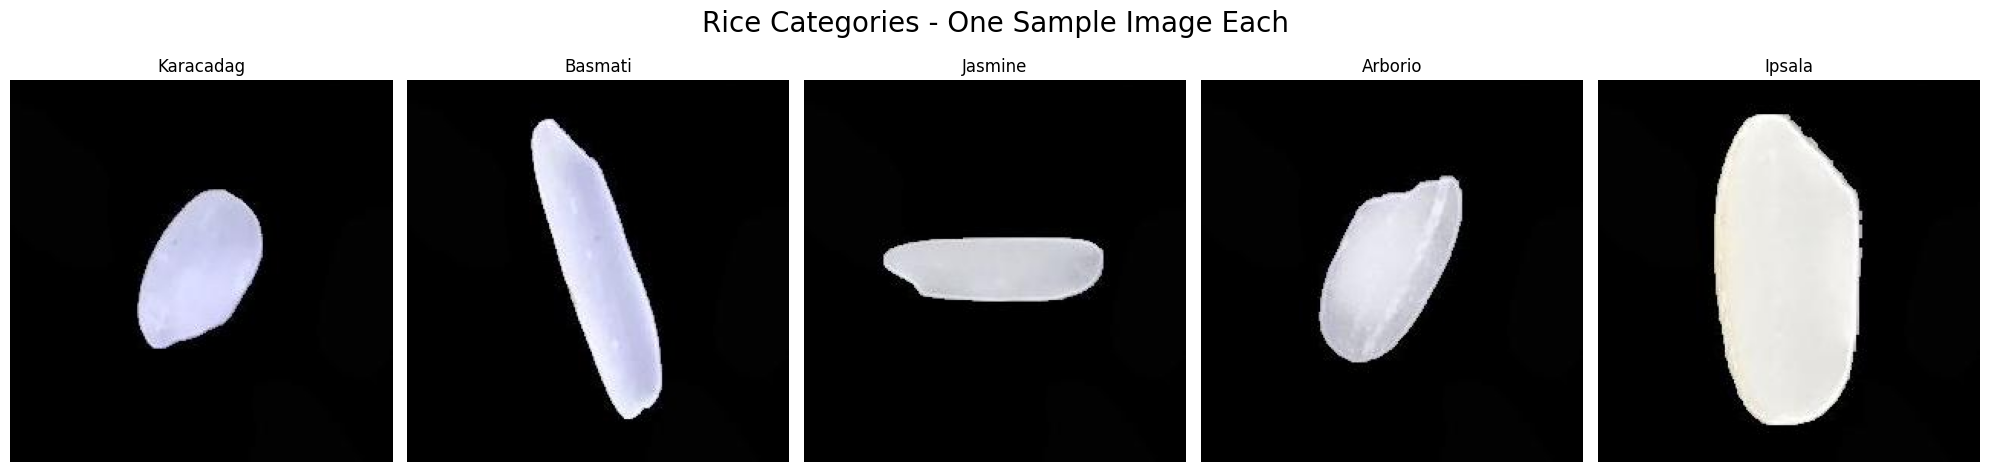

label
Karacadag    15000
Basmati      15000
Jasmine      15000
Arborio      15000
Ipsala       15000
Name: count, dtype: int64


In [7]:
# Visualize sample images from each class
# pathlib for easier path handling
path = pathlib.Path(dataset_path)

# Get unique class names from the DataFrame
classes = df['label'].unique()

# Plotting setup
fig, ax = plt.subplots(ncols=len(classes), figsize=(20, 5))
fig.suptitle('Rice Categories - One Sample Image Each', fontsize=20)

# Loop through classes and display one image each
for i, class_name in enumerate(classes):
    # Get one sample image path for the class
    sample_path = df[df['label'] == class_name]['image_path'].iloc[0]

    # Read and plot image
    img_data = mpimg.imread(sample_path)
    ax[i].imshow(img_data)
    ax[i].set_title(class_name)
    ax[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

# Show class distribution
print(df['label'].value_counts())

In [8]:
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df,
                                     test_size=0.3,
                                     stratify=df['label'],
                                     random_state=42)

val_df, test_df = train_test_split(temp_df,
                                   test_size=0.5,
                                   stratify=temp_df['label'],
                                   random_state=42)

# Sanity check
print("Total Images :", len(df))
print("Training Set :", len(train_df))
print("Validation Set:", len(val_df))
print("Test Set     :", len(test_df))

Total Images : 75000
Training Set : 52500
Validation Set: 11250
Test Set     : 11250


In [9]:
# Create visualization functions
def visualize_rice_samples(df, num_samples=5):
    """Visualize sample images from each rice class."""
    classes = df['label'].unique()

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    fig.suptitle('Rice Image Samples by Category', fontsize=16)

    for i, class_name in enumerate(classes):
        # Get image paths for this class
        class_samples = df[df['label'] == class_name]['image_path'].sample(num_samples).values

        for j, img_path in enumerate(class_samples):
            img = plt.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_ylabel(class_name, rotation=90, labelpad=15)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [21]:
def plot_training_history(history1, history2=None):
    """Plot training & validation accuracy and loss."""
    # Combine histories if fine-tuning was performed
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    epochs = range(1, len(acc) + 1) # epochs for the first training phase

    if history2:
        # Get the number of epochs from history2
        epochs2 = range(len(acc) + 1, len(acc) + len(history2.history['accuracy']) + 1)

        # Plot metrics from history2 using epochs2
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

        # Instead of combining, plot separate lines for fine-tuning
        plt.plot(epochs2, history2.history['accuracy'], 'b--', label='Training Accuracy (Fine-tuning)')
        plt.plot(epochs2, history2.history['val_accuracy'], 'r--', label='Validation Accuracy (Fine-tuning)')
        plt.plot(epochs2, history2.history['loss'], 'b--', label='Training Loss (Fine-tuning)')
        plt.plot(epochs2, history2.history['val_loss'], 'r--', label='Validation Loss (Fine-tuning)')

        # Update epochs for the entire training process
        epochs = range(1, len(acc) + 1)


    # Plot accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs[:len(history1.history['accuracy'])], history1.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs[:len(history1.history['val_accuracy'])], history1.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs[:len(history1.history['loss'])], history1.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs[:len(history1.history['val_loss'])], history1.history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ... (rest of the function remains the same) ...

In [11]:
def evaluate_model(model, test_generator):
    """Evaluate model and show detailed metrics."""
    # Get predictions
    test_generator.reset()
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Get true labels (need to extract from test_generator)
    y_true = test_generator.classes

    # Get class labels
    class_indices = test_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred,
                          target_names=list(class_labels.values()))
    print(report)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(class_labels.values()),
               yticklabels=list(class_labels.values()))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Return metrics for potential further use
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'class_labels': class_labels,
        'report': report
    }

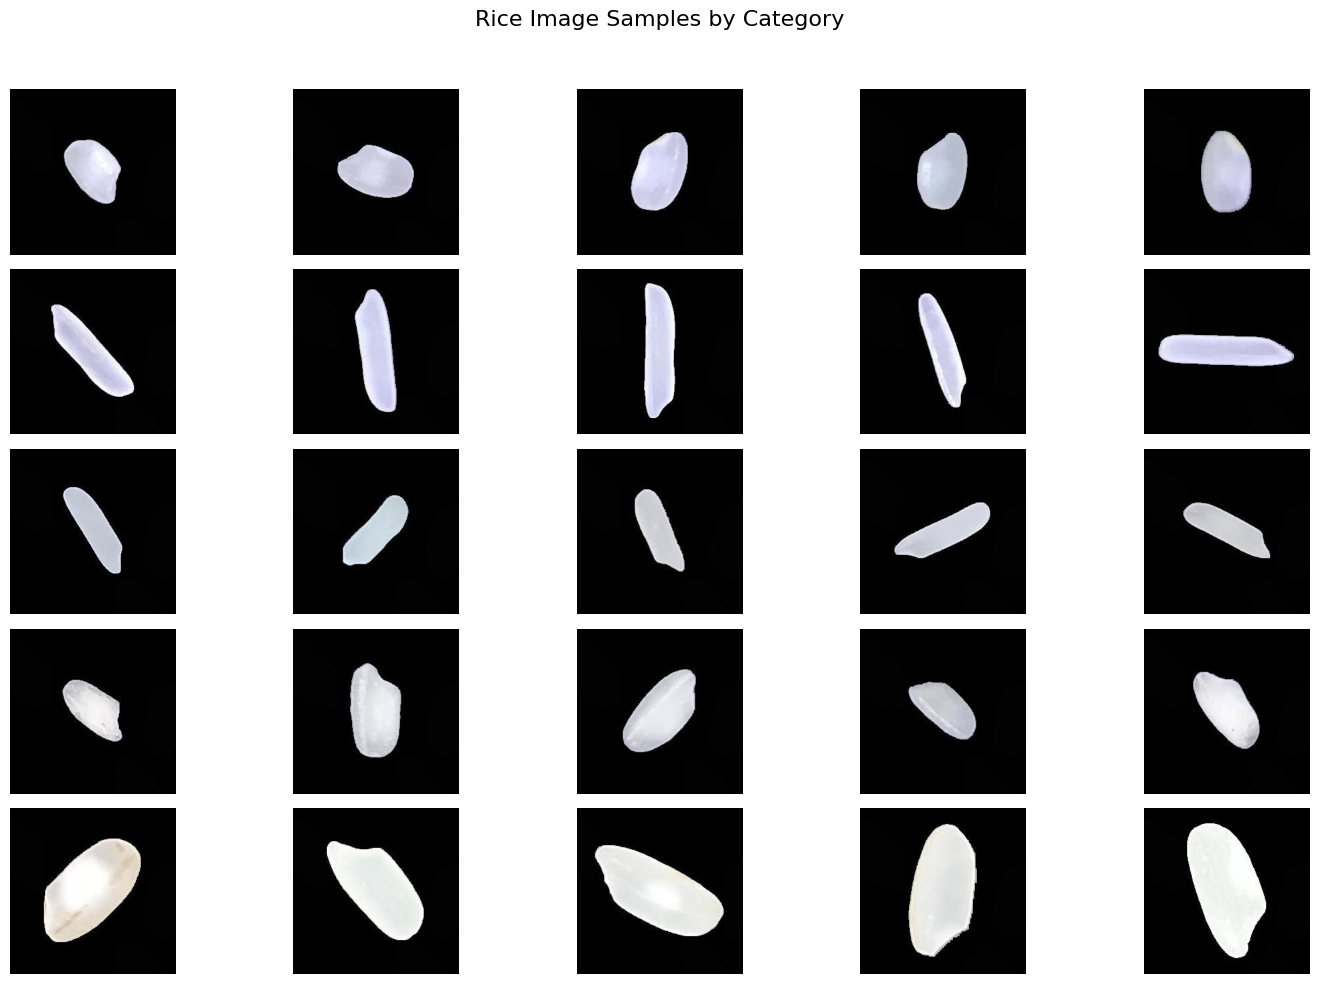

In [12]:
# Visualize sample images from each class
visualize_rice_samples(df, num_samples=5)

In [13]:
# Setup data generators with augmentation
# Define image parameters
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [14]:
# Enhanced data generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just preprocessing for validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [15]:
# Build the model using transfer learning with VGG16
NUM_CLASSES = len(train_df['label'].unique())

def build_model():
    # Load the base model
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=IMAGE_SHAPE+(3,)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create the model architecture
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compile the model with F1 score metric added
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1_score')  # Added F1 Score
        ]
    )

    return model, base_model

In [16]:
# Create callbacks for training
def create_callbacks():
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            'rice_classifier_best.h5',
            monitor='val_f1_score',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

In [17]:
# Build the model and view its architecture
model, base_model = build_model()
print(model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 396,805 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

None


In [18]:
# Train Phase 1 - Frozen base model
print("Phase 1: Training with frozen base model...")
callbacks = create_callbacks()

history1 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=5,
    callbacks=callbacks
)

Phase 1: Training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7835 - f1_score: 0.7826 - loss: 0.6057 - precision: 0.8190 - recall: 0.7492

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.967868   0.98200965 0.98489153 0.9593383  0.9755434 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1250s 752ms/step - accuracy: 0.7835 - f1_score: 0.7826 - loss: 0.6056 - precision: 0.8190 - recall: 0.7493 - val_accuracy: 0.9740 - val_f1_score: 0.9739 - val_loss: 0.0753 - val_precision: 0.9763 - val_recall: 0.9717 - learning_rate: 1.0000e-04
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9427 - f1_score: 0.9427 - loss: 0.1595 - precision: 0.9461 - recall: 0.9393

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.97258484 0.9828722  0.99249774 0.9690768  0.977828  ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 809s 493ms/step - accuracy: 0.9427 - f1_score: 0.9427 - loss: 0.1595 - precision: 0.9461 - recall: 0.9393 - val_accuracy: 0.9790 - val_f1_score: 0.9790 - val_loss: 0.0609 - val_precision: 0.9799 - val_recall: 0.9786 - learning_rate: 1.0000e-04
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9563 - f1_score: 0.9564 - loss: 0.1270 - precision: 0.9586 - recall: 0.9545

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.97377616 0.98873425 0.9922788  0.9781678  0.9794164 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 856s 489ms/step - accuracy: 0.9563 - f1_score: 0.9564 - loss: 0.1270 - precision: 0.9586 - recall: 0.9545 - val_accuracy: 0.9825 - val_f1_score: 0.9825 - val_loss: 0.0518 - val_precision: 0.9833 - val_recall: 0.9818 - learning_rate: 1.0000e-04
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9622 - f1_score: 0.9622 - loss: 0.1066 - precision: 0.9639 - recall: 0.9610

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.978714   0.988759   0.9931552  0.97809887 0.9833633 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 856s 485ms/step - accuracy: 0.9622 - f1_score: 0.9622 - loss: 0.1066 - precision: 0.9639 - recall: 0.9610 - val_accuracy: 0.9844 - val_f1_score: 0.9844 - val_loss: 0.0478 - val_precision: 0.9851 - val_recall: 0.9839 - learning_rate: 1.0000e-04
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9659 - f1_score: 0.9660 - loss: 0.1008 - precision: 0.9670 - recall: 0.9646

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9745042 0.9898454 0.9896635 0.9766704 0.9780493]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 820s 496ms/step - accuracy: 0.9659 - f1_score: 0.9660 - loss: 0.1008 - precision: 0.9670 - recall: 0.9646 - val_accuracy: 0.9818 - val_f1_score: 0.9817 - val_loss: 0.0555 - val_precision: 0.9826 - val_recall: 0.9812 - learning_rate: 1.0000e-04


In [19]:
# Train Phase 2 - Fine-tuning
print("Phase 2: Fine-tuning with unfrozen top layers...")
# Unfreeze the last few layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score')
    ]
)

# Continue training with fine-tuning
history2 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=5,
    callbacks=callbacks
)

Phase 2: Fine-tuning with unfrozen top layers...
Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9739 - f1_score: 0.9739 - loss: 0.0769 - precision: 0.9747 - recall: 0.9728

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9711934 0.9960088 0.9940358 0.9874439 0.9735521]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 830s 500ms/step - accuracy: 0.9739 - f1_score: 0.9739 - loss: 0.0769 - precision: 0.9747 - recall: 0.9728 - val_accuracy: 0.9844 - val_f1_score: 0.9844 - val_loss: 0.0430 - val_precision: 0.9845 - val_recall: 0.9844 - learning_rate: 1.0000e-05
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9870 - f1_score: 0.9870 - loss: 0.0423 - precision: 0.9874 - recall: 0.9866

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9704422  0.99665993 0.9942554  0.98428375 0.9758761 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 834s 487ms/step - accuracy: 0.9870 - f1_score: 0.9870 - loss: 0.0423 - precision: 0.9874 - recall: 0.9866 - val_accuracy: 0.9843 - val_f1_score: 0.9843 - val_loss: 0.0471 - val_precision: 0.9843 - val_recall: 0.9840 - learning_rate: 1.0000e-05
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9903 - f1_score: 0.9903 - loss: 0.0309 - precision: 0.9904 - recall: 0.9900

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9683394  0.9966689  0.99359673 0.98834074 0.9690721 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 810s 491ms/step - accuracy: 0.9903 - f1_score: 0.9903 - loss: 0.0309 - precision: 0.9904 - recall: 0.9900 - val_accuracy: 0.9832 - val_f1_score: 0.9832 - val_loss: 0.0488 - val_precision: 0.9836 - val_recall: 0.9830 - learning_rate: 1.0000e-05
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9910 - f1_score: 0.9910 - loss: 0.0280 - precision: 0.9913 - recall: 0.9907

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.97653186 0.99665844 0.9946949  0.98951584 0.9777373 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 857s 489ms/step - accuracy: 0.9910 - f1_score: 0.9910 - loss: 0.0280 - precision: 0.9913 - recall: 0.9907 - val_accuracy: 0.9870 - val_f1_score: 0.9870 - val_loss: 0.0386 - val_precision: 0.9873 - val_recall: 0.9869 - learning_rate: 1.0000e-05
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9911 - f1_score: 0.9912 - loss: 0.0283 - precision: 0.9914 - recall: 0.9908

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9940172  0.9942478  0.9962364  0.98765975 0.9971066 ]. Falling back to `save_best_only=False`.
  warnings.warn(


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 821s 501ms/step - accuracy: 0.9911 - f1_score: 0.9912 - loss: 0.0283 - precision: 0.9914 - recall: 0.9908 - val_accuracy: 0.9939 - val_f1_score: 0.9939 - val_loss: 0.0181 - val_precision: 0.9941 - val_recall: 0.9935 - learning_rate: 1.0000e-05


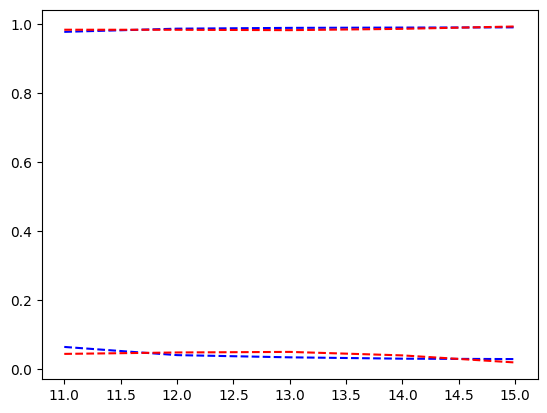

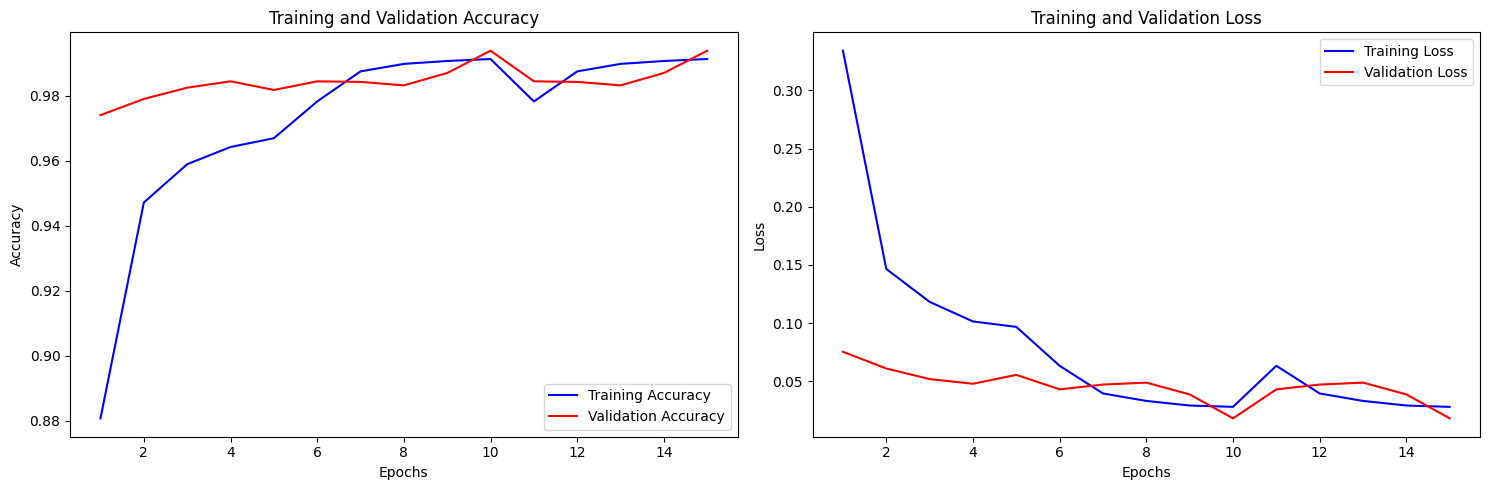

In [22]:
# Plot training history
plot_training_history(history1, history2)

In [24]:
# Evaluate model on test set
print("Evaluating model on test set...")
test_results = model.evaluate(test_gen)



Evaluating model on test set...
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 163ms/step - accuracy: 0.9942 - f1_score: 0.9942 - loss: 0.0155 - precision: 0.9943 - recall: 0.9941


In [25]:
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

Test Loss: 0.0160
Test Accuracy: 0.9947
Test Precision: 0.9948
Test Recall: 0.9945


In [26]:
print(f"Test F1 Score: {test_results[4][0]:.4f}")

Test F1 Score: 0.9938


352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      2250
     Basmati       0.99      1.00      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       1.00      0.98      0.99      2250
   Karacadag       1.00      1.00      1.00      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



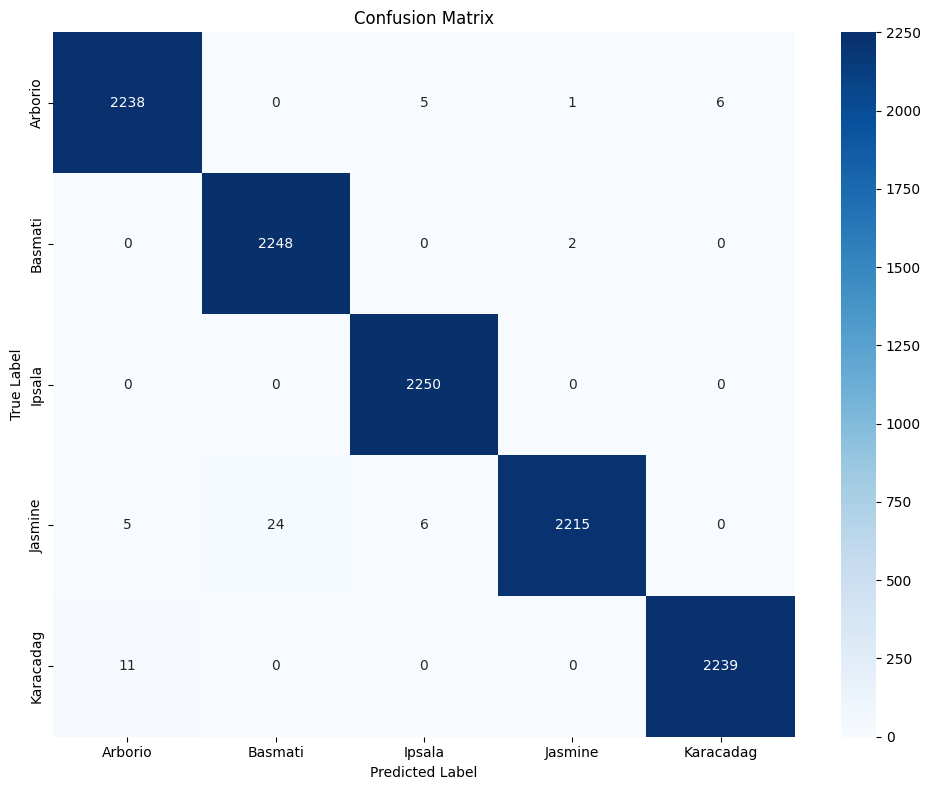

In [27]:
# Generate detailed evaluation metrics and visualizations
metrics = evaluate_model(model, test_gen)

In [28]:
# Save the final model
model.save('rice_classifier_final.h5')
print("Model saved as 'rice_classifier_final.h5'")

Model saved as 'rice_classifier_final.h5'


In [29]:
# Create UI for image upload and prediction
# Install Gradio if needed
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.9 MB/s eta 0:00:00


In [30]:
import gradio as gr

In [31]:
# Function to preprocess image
def preprocess_image(image):
    """Preprocess image for model prediction."""
    # Convert to array if needed
    if isinstance(image, str):
        image = plt.imread(image)

    # Resize and preprocess
    image = tf.image.resize(image, IMAGE_SHAPE)
    image = preprocess_input(image)
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to make prediction
def predict_rice(image):
    """Predict rice type from uploaded image."""
    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)

    # Get class names
    class_names = list(train_gen.class_indices.keys())

    # Create results dictionary
    class_probabilities = {
        name: float(prob)
        for name, prob in zip(class_names, prediction[0])
    }

    # Return sorted results (highest probability first)
    return {k: v for k, v in sorted(class_probabilities.items(),
                                   key=lambda item: item[1],
                                   reverse=True)}

# Create Gradio interface
iface = gr.Interface(
    fn=predict_rice,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=5),
    title="Rice Type Classifier",
    description="Upload an image of rice grains to identify the type",
    article="""
    ## About this Rice Classifier

    This classifier can identify 5 different types of rice:
    - Arborio - used in risotto, characterized by plump grains
    - Basmati - long-grain aromatic rice from India and Pakistan
    - Ipsala - medium-grain rice from Turkey
    - Jasmine - fragrant long-grain rice from Thailand
    - Karacadag - an ancient rice variety from Turkey

    For best results, ensure your image:
    - Shows clear rice grains
    - Has good lighting
    - Contains only rice (no other foods or objects)
    """
)

# Launch the UI
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://10c18328ee1c109095.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
